# Fake News Detection with Adversarial Normalization

Notebook with implemenation and testing for applying Adversarial Neural Networks to the task of Fake News Detection. Part of the project for Northeastern University's Khoury College course on Practical Neural Networks (DS 4440), during Fall 2020.

This notebook preprocess the data generating usable datasets as `.csv` files


Note: this notebook expects the data to be used to be located on a Google Drive account on a specific path. This *can* be modified.

See README at https://github.com/pablokvitca/ds4440-project for more details.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import ast
from time import time
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
source_folder = '/content/drive/My Drive/Projects/Academic/NN/data/'

In [ ]:
raw_data_path = source_folder + "news_wkta_all.csv.zip"

In [ ]:
df_raw = pd.read_csv(
    raw_data_path, 
    nrows=2_000_000,
    encoding="utf-8", quotechar='"',
    low_memory=True, memory_map=True,
    engine="c", compression="zip", 
    error_bad_lines=False, warn_bad_lines=True
)
df_raw.shape

(2000000, 307)

In [ ]:
metadata_counts_path = source_folder + "metadata_counts.python_output"

In [ ]:
counts_keywords = Counter()
counts_tags = Counter()
counts_authors = Counter()
with open(metadata_counts_path, 'r') as file:
    data = file.read().split("Counter(")
    
    counts_keywords.update(ast.literal_eval(data[1][:-2]))
    counts_tags.update(ast.literal_eval(data[2][:-2]))
    counts_authors.update(ast.literal_eval(data[3][:-2]))



In [ ]:
counts_keywords.most_common(25)

[('climate change', 313727),
 ('business', 258123),
 ('energy', 220365),
 ('renewables', 192477),
 ('health', 105349),
 ('food', 100328),
 ('biodiversity', 98606),
 ('sustainable business', 97040),
 ('coal', 75628),
 ('fracking', 74660),
 ('politics', 73086),
 ('science', 66711),
 ('china', 42220),
 ('ebola', 33690),
 ('cuba', 33528),
 ('cop21', 32877),
 ('pipelines', 32852),
 ('russia', 32836),
 ('tips', 32300),
 ('transportation', 31966),
 ('donald trump', 26632),
 ('united states', 23972),
 ('barack obama', 20173),
 ('hillary clinton', 17902),
 ('economics', 17598)]

In [ ]:
counts_tags.most_common(25)

[('russia', 65416),
 ('donald trump', 60004),
 ('hillary clinton', 42836),
 ('syria', 35145),
 ('9/11 articles', 31523),
 ('race/crime articles', 31523),
 ('american pravda articles', 31523),
 ('race/iq articles', 31523),
 ('israel', 31399),
 ('libya', 30813),
 ('united states', 30101),
 ('immigration', 29121),
 ('politics', 28905),
 ('barack obama', 25986),
 ('trump', 25812),
 ('obama', 24607),
 ('isis', 24055),
 ('europe', 23574),
 ('iran', 23016),
 ('china', 22821),
 ('cia', 22379),
 ('benghazi', 22064),
 ('children', 21172),
 ('terrorism', 20555),
 ('islam', 20424)]

In [ ]:
counts_authors.most_common(25)

[('lorraine chow', 746451),
 ('common dreams', 638516),
 ('guest contributor', 507058),
 ('the conversation', 384011),
 ('david leestma', 362631),
 ('environmental working group', 254739),
 ('ronnie cummins', 254659),
 ('the climate reality project', 254658),
 ('sierra club', 254636),
 ('rainforest action network', 254636),
 ('backgroundurl avatar_large', 224956),
 ('organic consumers association', 156531),
 ("our children's trust", 107978),
 ('american wild horse campaign', 107975),
 ('anastasia pantsios', 101821),
 ('stefanie spear', 98031),
 ('climate nexus', 82670),
 ('daily kos', 76786),
 ('happy cog studios - http', 76783),
 ('www.happycog.com', 76783),
 ('david codrea', 70085),
 ('tom mchale', 70085),
 ('jeff knox', 70085),
 ('the revelator', 49938),
 ('climate group', 49922)]

In [ ]:
def filter_data_by_meta(df, prefix, meta_counts, n):
    req_cols = [prefix + meta for meta, _ in meta_counts.most_common(n)]
    
    all_criteria = [df[col] == 1 for col in req_cols]
    criteria = df[req_cols[0]] == 1
    for col in req_cols[1:]:
        criteria = criteria | df[col] == 1
        
    return df.loc[criteria]

In [ ]:
df_raw.shape

(2000000, 307)

In [ ]:
df_raw.drop_duplicates(inplace=True)
df_raw.reset_index()
df_raw.shape

(1302734, 307)

In [ ]:
filtered_data = filter_data_by_meta(df_raw, "has_mk_", counts_keywords, 20)

In [ ]:
filtered_data.shape

(39063, 307)

In [ ]:
filtered_data = filtered_data.copy()

In [ ]:
len(df_raw.domain.unique())

379

In [ ]:
len(filtered_data.domain.unique())

66

In [ ]:
del df_raw

In [ ]:
print(filtered_data.fake.value_counts(normalize=False))
print(filtered_data.fake.value_counts(normalize=True))

1    23837
0    15226
Name: fake, dtype: int64
1    0.610219
0    0.389781
Name: fake, dtype: float64


In [ ]:
filtered_data.to_csv(source_folder + "news_filtered.csv", index=False)

In [ ]:
def clean_join_text_cols(df, col_a, col_b, out_col):
    def clean_text_col(d):
        return " \n ".join(d.splitlines())
    df[out_col] = df[[col_a, col_b]].apply(lambda r: clean_text_col(r[col_a]) + " <ENDTITLE> \n " + clean_text_col(r[col_b]), axis=1)

In [ ]:
clean_join_text_cols(filtered_data, "title", "content", "title_content")

In [ ]:
filtered_data["content_length"] = filtered_data.content.apply(lambda d: len(d.split()))
filtered_data["title_length"] = filtered_data.title.apply(lambda d: len(d.split()))
filtered_data["total_length"] = filtered_data.content.apply(lambda d: len(d.split()))

In [ ]:
filtered_data.shape

(39063, 311)

In [ ]:
no_dups = filtered_data.drop_duplicates()
no_dups.shape

(39063, 311)

In [ ]:
filtered_data["total_length"].describe()

count    39063.000000
mean       467.514707
std        623.874759
min          7.000000
25%        149.000000
50%        312.000000
75%        603.000000
max      17642.000000
Name: total_length, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


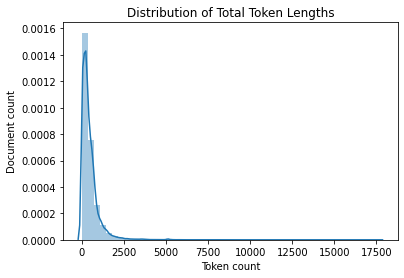

In [ ]:
sns.distplot(filtered_data["total_length"])
# plt.xlim([0, 1024]);
plt.xlabel('Token count');
plt.ylabel('Document count')
plt.title("Distribution of Total Token Lengths")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


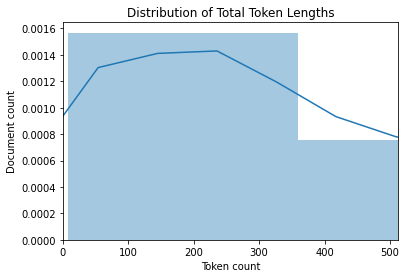

In [ ]:
sns.distplot(filtered_data["total_length"])
plt.xlim([0, 512]);
plt.xlabel('Token count');
plt.ylabel('Document count')
plt.title("Distribution of Total Token Lengths")
plt.show()

In [ ]:
def get_keyword_col_names(df, prefix="has_mk_"):
    return [col for col in df.columns if "has_mk_" in col]
keyword_cols = get_keyword_col_names(filtered_data)
prefix = "has_mk_"
most_common_keywords = [prefix + k[0] for k in counts_keywords.most_common(20)]

In [ ]:
def get_most_common_keyword_for_news_item(item):
    for col in most_common_keywords:
        if item[col] == 1:
            return col[len(prefix):]
    return 0

In [ ]:
filtered_data["keyword"] = filtered_data.apply(get_most_common_keyword_for_news_item, axis=1)

In [ ]:
print(filtered_data.keyword.value_counts(normalize=False))
print(filtered_data.keyword.value_counts(normalize=True))

politics                12110
russia                  11084
china                    3427
health                   3285
energy                   2056
business                 1640
climate change           1606
science                  1374
food                     1054
cuba                      430
ebola                     205
fracking                  198
biodiversity              196
transportation            146
coal                      121
tips                       98
pipelines                  18
renewables                  8
cop21                       6
sustainable business        1
Name: keyword, dtype: int64
politics                0.310012
russia                  0.283747
china                   0.087730
health                  0.084095
energy                  0.052633
business                0.041983
climate change          0.041113
science                 0.035174
food                    0.026982
cuba                    0.011008
ebola                   0.005248
fracking 

In [ ]:
unbalanced_train_set, unbalanced_test_set = train_test_split(filtered_data, test_size = 0.1, random_state = 1001)
unbalanced_train_set, unbalanced_validation_set = train_test_split(unbalanced_train_set, test_size = 0.1, random_state = 1001)

In [ ]:
unbalanced_train_set.to_csv(source_folder + "train_unbalanced.csv", index=False)
unbalanced_test_set.to_csv(source_folder + "test_unbalanced.csv", index=False)
unbalanced_validation_set.to_csv(source_folder + "validation_unbalanced.csv", index=False)

In [ ]:
print(unbalanced_train_set.fake.value_counts(normalize=False))
print(unbalanced_train_set.fake.value_counts(normalize=True))

1    19315
0    12325
Name: fake, dtype: int64
1    0.610461
0    0.389539
Name: fake, dtype: float64


In [ ]:
print(unbalanced_test_set.fake.value_counts(normalize=False))
print(unbalanced_test_set.fake.value_counts(normalize=True))

1    2362
0    1545
Name: fake, dtype: int64
1    0.604556
0    0.395444
Name: fake, dtype: float64


In [ ]:
print(unbalanced_validation_set.fake.value_counts(normalize=False))
print(unbalanced_validation_set.fake.value_counts(normalize=True))

1    2160
0    1356
Name: fake, dtype: int64
1    0.614334
0    0.385666
Name: fake, dtype: float64


In [ ]:
BALANCED_N = 10_000

In [ ]:
balanced_real = filtered_data[filtered_data["fake"] == 0].sample(BALANCED_N, random_state = 1001)
balanced_fake = filtered_data[filtered_data["fake"] == 1].sample(BALANCED_N, random_state = 1001)
balanced_data = balanced_real.append(balanced_fake)

In [ ]:
balanced_train_set, balanced_test_set = train_test_split(balanced_data, test_size = 0.1, random_state = 1001)
balanced_train_set, balanced_validation_set = train_test_split(balanced_train_set, test_size = 0.1, random_state = 1001)

In [ ]:
balanced_train_set.to_csv(source_folder + "train_balanced.csv", index=False)
balanced_test_set.to_csv(source_folder + "test_balanced.csv", index=False)
balanced_validation_set.to_csv(source_folder + "validation_balanced.csv", index=False)

In [ ]:
print(balanced_train_set.fake.value_counts(normalize=False))
print(balanced_train_set.fake.value_counts(normalize=True))

1    8100
0    8100
Name: fake, dtype: int64
1    0.5
0    0.5
Name: fake, dtype: float64


In [ ]:
print(balanced_test_set.fake.value_counts(normalize=False))
print(balanced_test_set.fake.value_counts(normalize=True))

1    1015
0     985
Name: fake, dtype: int64
1    0.5075
0    0.4925
Name: fake, dtype: float64


In [ ]:
print(balanced_validation_set.fake.value_counts(normalize=False))
print(balanced_validation_set.fake.value_counts(normalize=True))

0    915
1    885
Name: fake, dtype: int64
0    0.508333
1    0.491667
Name: fake, dtype: float64
